The following notebook intends to resume our procedure validation model. We hope you enjoy it.
Please feel free to contact us at dnb0512@gmail.com 

## Our Hypothesis.

We pursue to build a deep learning model that allows us to calculate how likely is a failure can occur over a fixed time. There's no point in debating if it is or isn't feasible as it becomes a matter of how much computational power is needed to achieve it. The need for quick and easy models must be part of the problem solution.

We know our approach is not as easy to digest, and at its best, is a leap of faith. Don't worry; we had doubts too, that's why we build an "easy" model to get a glimpse at our final product. Throughout this notebook, you'll find its outcomes and findings. 

The elephant in the room, holding little to no attention, is the need for an IoT device that enables current and pressure sensors reding, filtering data alongside server communication. Rest assured, we're conscious of its use case, and we're working towards releasing our solution soon.

### What did we do?
Our approach to the problem relies on two premises:
- Anomaly patterns are detectable using duty point tracking.
- Pump/system indicators can improve model performance and predictive capabilities. 

We designed a simple experiment to assess the feasibility. Like most of you know, close valve operation is a critical operation point for any pump; it also is easy to accomplish using a gate valve. With this in mind, we built a test bench using three Pedrollo CPM-600 0.5 HP 1Ph 115V, where we forced 82 operations event cycles. Then used the data to generate over 30 different models based on our hypothesis to obtained the following results.
 

In [1]:
import matplotlib
%matplotlib inline
matplotlib.use
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

Let's have a look at the collected pump training data and its processing. Using an Arduino Mega board, we gathered data from ACS712's current sensor and Danfos' MBS1900 pressure transducers. (We implemented XY-IY0V module for the 4-20mA signal to 0-5VDC conversion.)

The experiment employed Python for data processing, taking into account the following assumptions:
- Our system registered an average of 5 data points per second.
- Timestamps were irrelevant as we could say that a data point was a day, month, etc. But to reduce computational power median filter was used on 300 samples.

In [2]:
close_valve=pd.read_csv('Final.csv')
close_valve.drop(['Unnamed: 0','status','Voltaje1'],axis=1,inplace=True)
close_valve.head()

,Amperaje1,Presion1,ciclo,tiempo
0,5.07,1.33,0,0
1,5.11,1.34,0,1
2,5.07,1.30,0,2
3,5.05,1.33,0,3
4,5.03,1.41,0,4


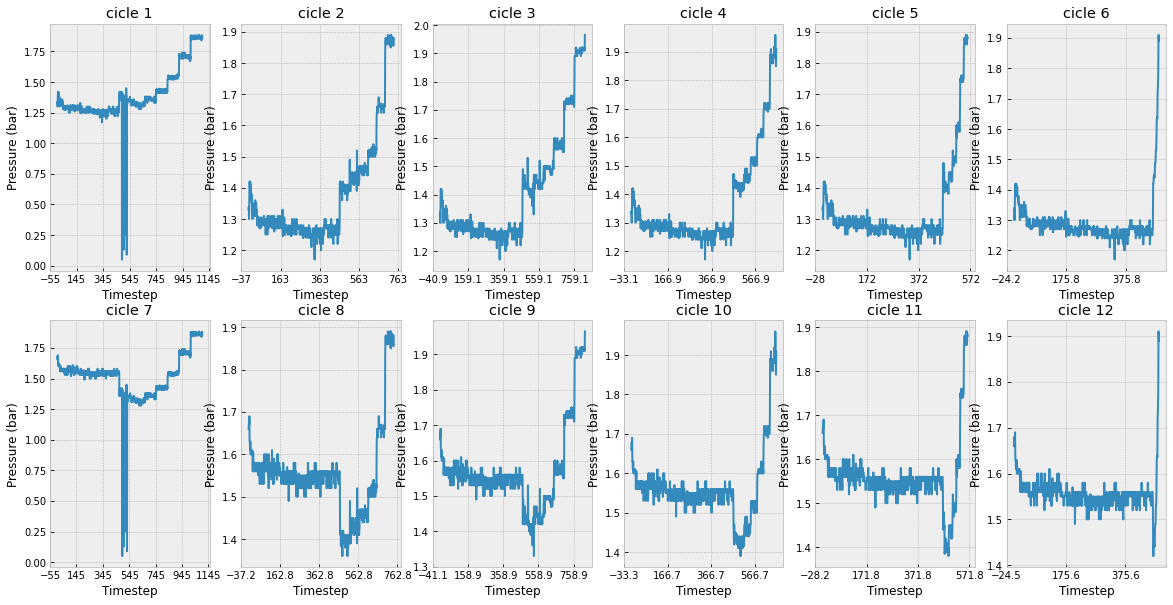

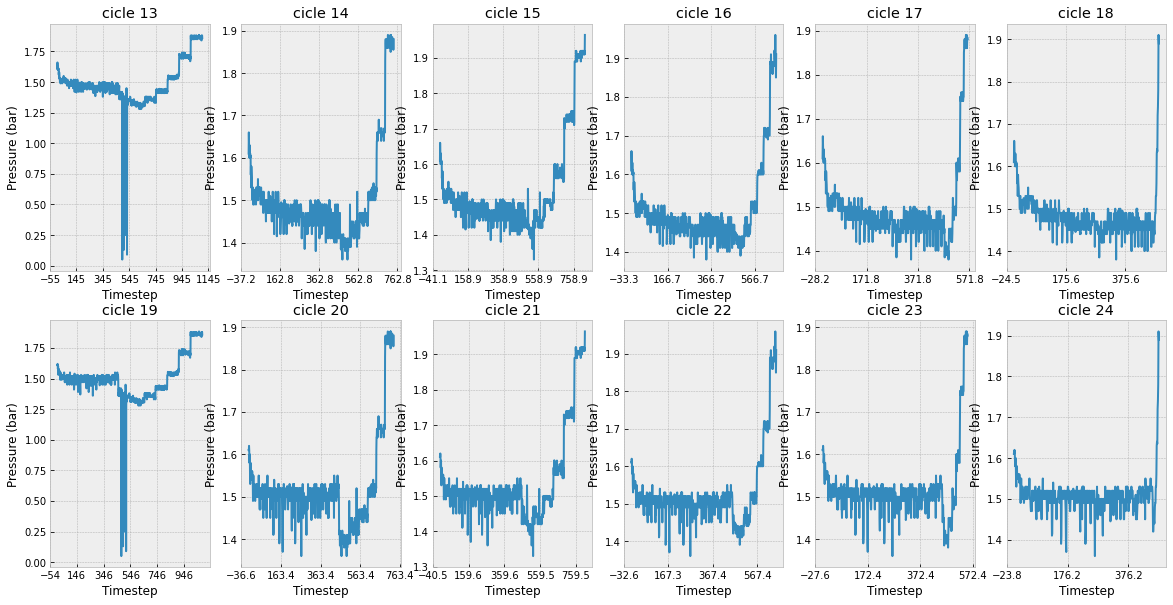

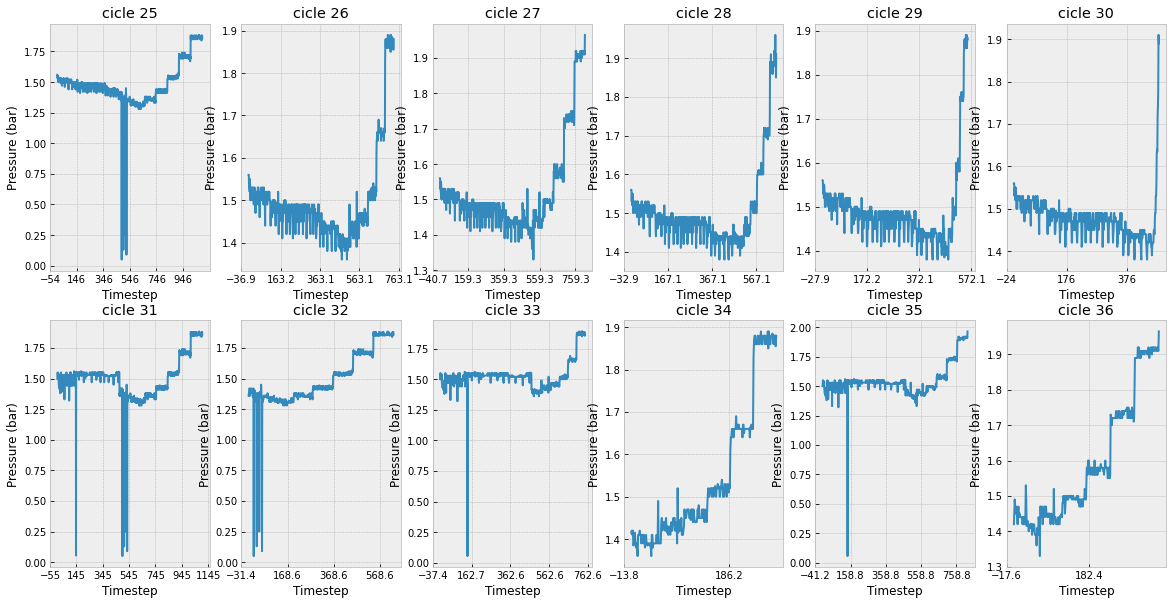

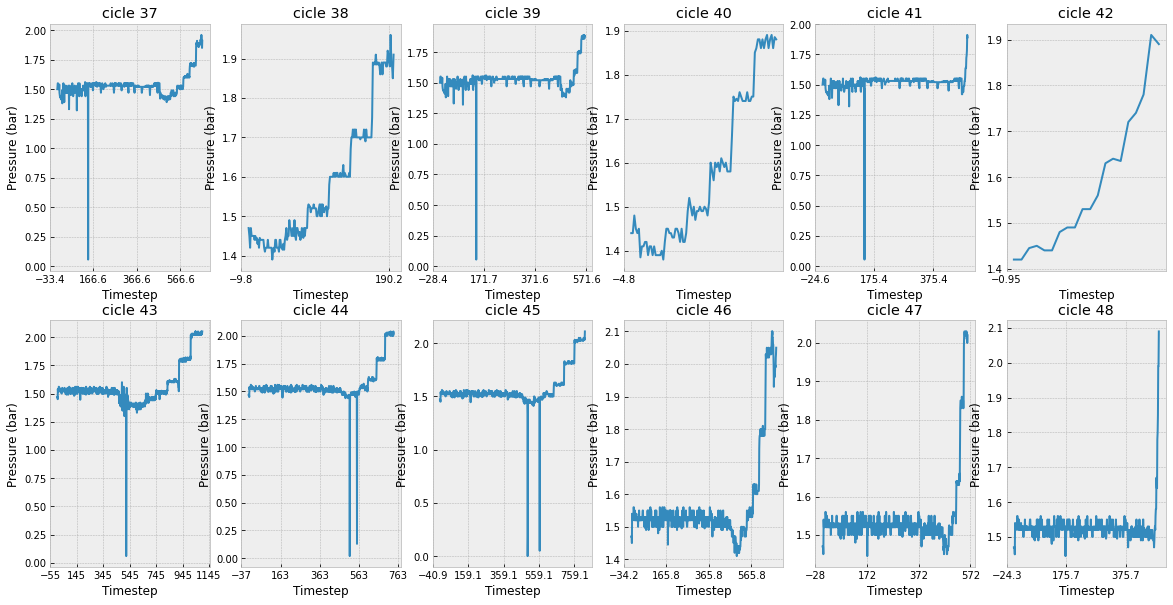

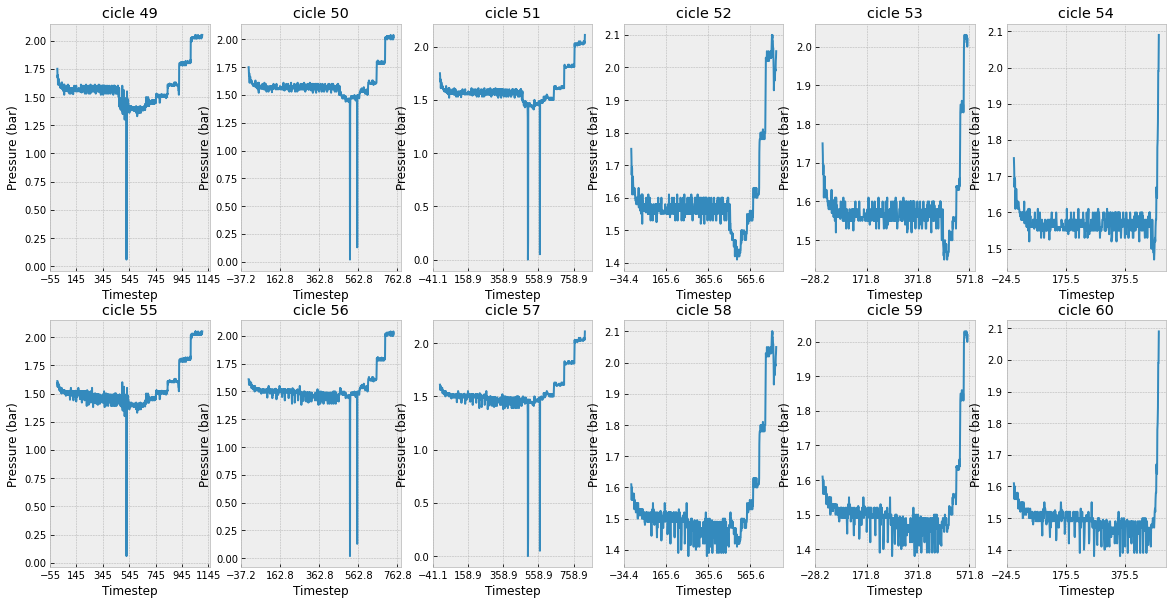

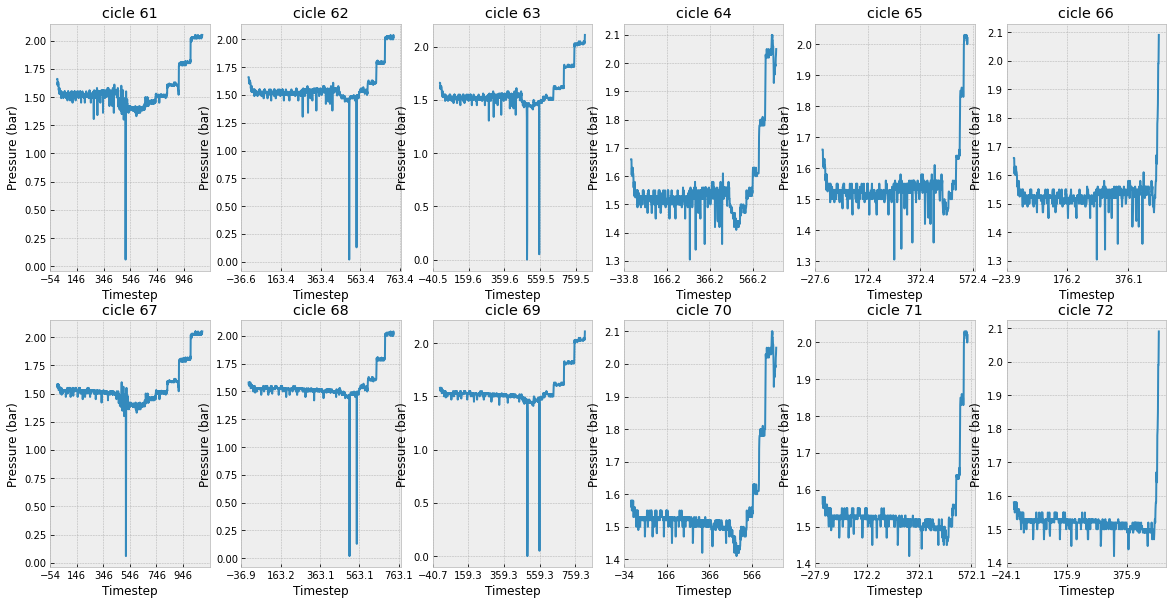

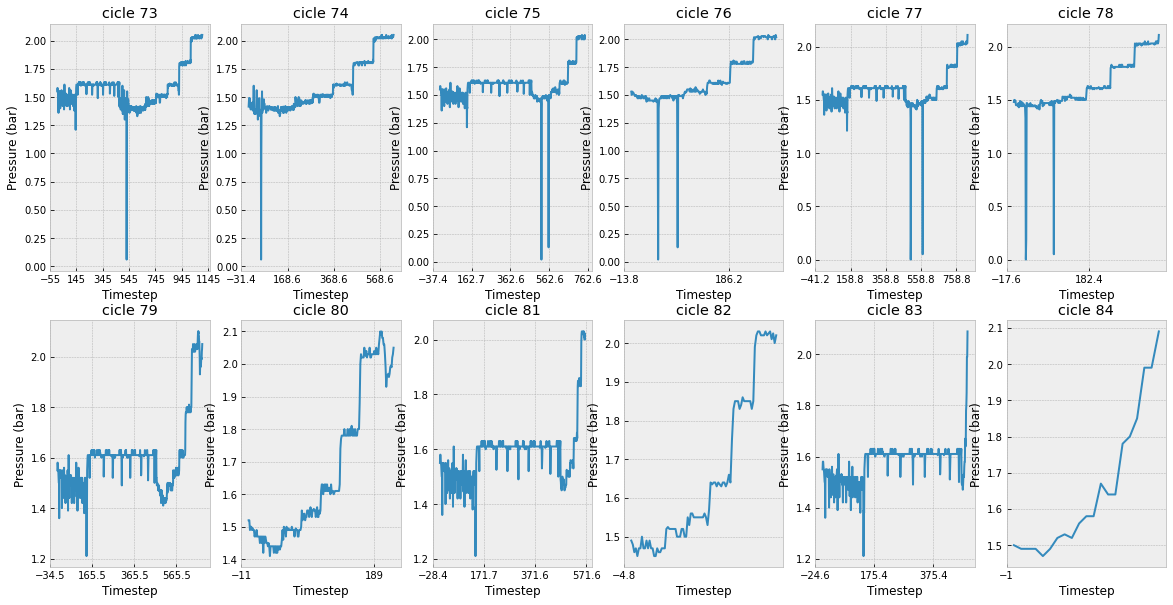

In [3]:
figure=1
while figure<84:
  plt.style.use('bmh')
  fig, ax1= plt.subplots(nrows=2,ncols=6,figsize=(20,10))
  ind=figure-1
  for j in ax1:
    for i in j:
      i.plot(close_valve.loc[close_valve['ciclo']==ind]['tiempo'],close_valve.loc[close_valve['ciclo']==ind]['Presion1'])
      i.title.set_text(f'cicle {ind}')
      i.set_ylabel('Pressure (bar)')
      i.set_xlabel('Timestep')
      start,end=[0,0]
      start, end = i.get_xlim()
      i.xaxis.set_ticks(np.arange(start, end, 200))
      ind+=1
      i.title.set_text(f'cicle {ind}')
  figure+=12

The data has a lot of noise due to the nature of our sensors. Arduino code intentionally neglected to address these to avoid compromising the delivery of accessible, low-cost IoT. In contrast, the model would benefit from the natural approach as noise tends to help prevent overfitting. Thi for us as we're using such generalization (the experiment uses one pump model training data to predict all pumps' behavior**) is helpful. 

** Selection includes centrifugal pumps as their dynamics do not vary when propelling the broad approach.
 

### Did it work?
We have reason to believe it did; Our model predicts how many timesteps were left until reached maximum pressure in five randomly selected pumps and six different operating pressure cycles. 

In [4]:
model_results_full=pd.read_csv('Model_results_full.csv').transpose()
model_results_partial=pd.read_csv('Model_results_partial.csv').transpose()
pump_performance=pd.read_csv('Pump_perfomance.csv')
graphs=pd.DataFrame()
partial=[]
for j in pump_performance['ciclo'].unique():
  predictions_full= np.array(model_results_full[j][~np.isnan(model_results_full[j])])[1:]
  predictions_partial= np.array(model_results_partial[j][~np.isnan(model_results_partial[j])])[1:]
  final=pump_performance.loc[pump_performance['ciclo']==j]
  final['time_full']=predictions_full
  partial.append(predictions_partial)
  graphs=graphs.append(final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

The following lines of code will graph our conclusions while addressing each objective individually.

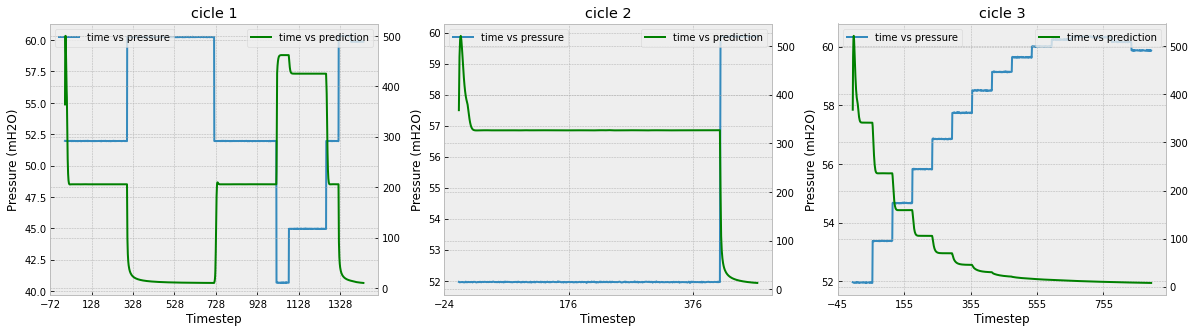

In [5]:
fig, ax1= plt.subplots(nrows=1,ncols=3,figsize=(20,5))
plt.style.use('bmh')
ind=0
for i in ax1:
  i.plot(graphs.loc[graphs['ciclo']==ind]['tiempo'],graphs.loc[graphs['ciclo']==ind]['presion'])
  ax2=i.twinx()
  ax2.plot(graphs.loc[graphs['ciclo']==ind]['tiempo'],graphs.loc[graphs['ciclo']==ind]['time_full'],c='g')
  i.title.set_text(f'cicle {ind}')
  i.set_ylabel('Pressure (mH2O)')
  i.set_xlabel('Timestep')
  start,end=[0,0]
  start, end = i.get_xlim()
  i.xaxis.set_ticks(np.arange(start, end, 200))
  ind+=1
  i.title.set_text(f'cicle {ind}')
  i.legend(['time vs pressure'],loc='upper left')
  ax2.legend(['time vs prediction'],loc='upper right')

Pumps duty points are relatively easy to track for any human; a plot of the curve and the operating pressure in a given moment is enough information for us. A computer program can also perform the same with an additional set of data. So, why are the above graphs considered a milestone? To answer that, let's ensure we understand the feedback obtained from reading a pump curve. In a quick summary:

- Duty point location is a consequence of the system dynamics; therefore, any change will reflect a movement on it.
- Euclidean, Manhattan, or any other distance measurements are practical for unique case analysis, but you need more advanced tools for generalization; hence the probability of a given specific type of pump comes into play.

In summary, the graph above shows our model prediction (in timesteps remaining) to each duty point on three different systems dynamics, where each calculation only uses the information obtained before it. The power of that conclusion is that our system can track duty points from a reference in a more generalized picture. Regardless of the pump model, it can identify the duty point behavior on the system dynamics.

The following three graphs display the PDF in differents timesteps.

Text(0, 0.5, 'Pressure(mH2o)')

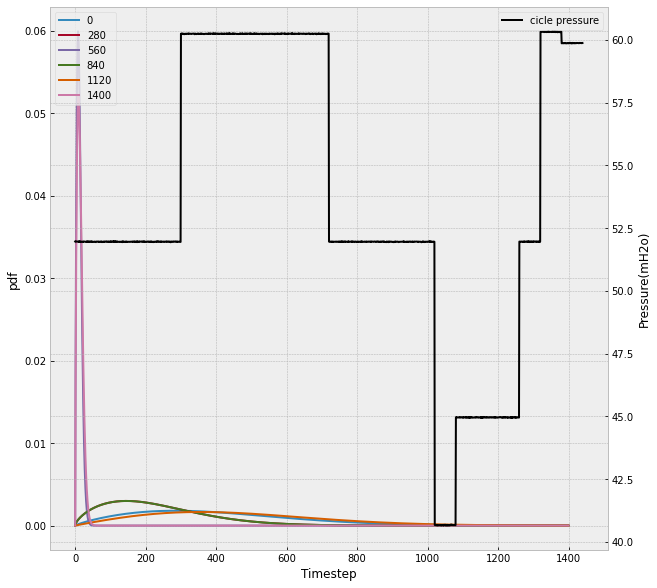

In [13]:
zero_pdf=pd.read_csv('casezero-pdf.csv')
plt.style.use('bmh')
plt.figure(figsize=(10,10))
t=np.arange(0,1440)
ind=list(range(0,1440,280))
for i in ind:
  plt.plot(zero_pdf[f'{i}'])
plt.legend(ind,loc='upper left')
plt.ylabel('pdf')
plt.xlabel('Timestep')
ax2=plt.twinx()
ax2.plot(graphs.loc[graphs['ciclo']==0]['tiempo'],graphs.loc[graphs['ciclo']==0]['presion'],c='k')
ax2.legend(['cicle pressure'],loc=('upper right'))
ax2.set_ylabel('Pressure(mH2o)')

Text(0, 0.5, 'Pressure(mH2o)')

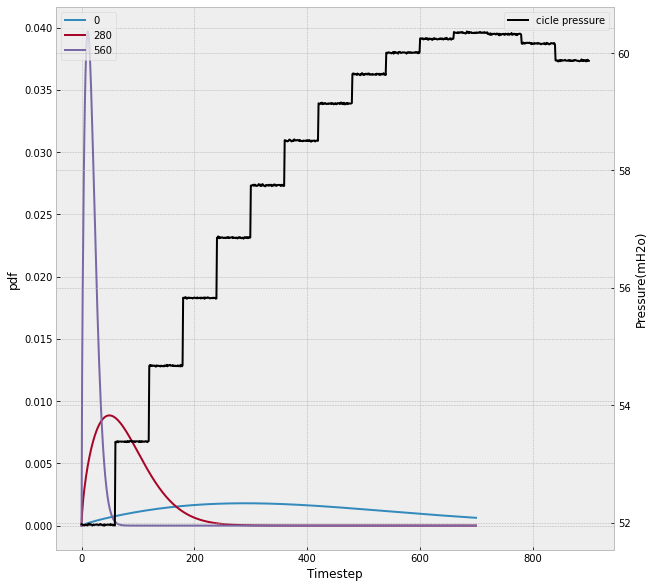

In [6]:
zero_pdf=pd.read_csv('casetwo-pdf.csv')
plt.style.use('bmh')
plt.figure(figsize=(10,10))
t=np.arange(0,700)
ind=list(range(0,700,280))
for i in ind:
  plt.plot(zero_pdf[f'{i}'])
plt.legend(ind,loc='upper left')
plt.ylabel('pdf')
plt.xlabel('Timestep')
ax2=plt.twinx()
ax2.plot(graphs.loc[graphs['ciclo']==2]['tiempo'],graphs.loc[graphs['ciclo']==2]['presion'],c='k')
ax2.legend(['cicle pressure'],loc=('upper right'))
ax2.set_ylabel('Pressure(mH2o)')

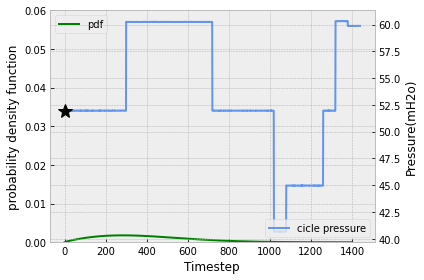

In [15]:
#@title
zero_pdf=pd.read_csv('casezero-pdf.csv')
from matplotlib import animation
plt.style.use('bmh')
fig,ax= plt.subplots()
fig.set_tight_layout(True)
t=np.arange(0,1400)
ind=list(range(0,1400,1))
line, = ax.plot(t,t*0,c='green', linewidth=2)
plt.legend(['pdf'],loc='upper left')
plt.ylabel('probability density function')
plt.xlabel('Timestep')
ax.set_ylim([0,0.06])
ax2=plt.twinx()
ax2.plot(graphs.loc[graphs['ciclo']==0]['tiempo'],graphs.loc[graphs['ciclo']==0]['presion'],c='cornflowerblue')
ax2.legend(['cicle pressure'],loc=('lower right'))
ax2.set_ylabel('Pressure(mH2o)')
line2, =ax2.plot(0,graphs.loc[graphs['ciclo']==0]['presion'][0],marker='*',ms=15,c='k')
def animate(i):
  label=zero_pdf[f'{ind[i]}']
  line.set_ydata(label)
  line2.set_data(ind[i],graphs.loc[graphs['ciclo']==0]['presion'][ind[i]])
  return line, ax

anim=animation.FuncAnimation(fig,animate,frames=np.arange(0,1400),interval=10)
writergif = animation.PillowWriter(fps=45)
anim.save('line.gif',writer=writergif)
plt.show()

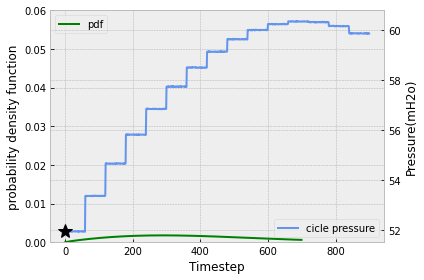

In [8]:
#@title
zero_pdf=pd.read_csv('casetwo-pdf.csv')
from matplotlib import animation
plt.style.use('bmh')
fig,ax= plt.subplots()
fig.set_tight_layout(True)
t=np.arange(0,700)
ind=list(range(0,700,1))
line, = ax.plot(t,t*0,c='green', linewidth=2)
plt.legend(['pdf'],loc='upper left')
plt.ylabel('probability density function')
plt.xlabel('Timestep')
ax.set_ylim([0,0.06])
ax2=plt.twinx()
ax2.plot(graphs.loc[graphs['ciclo']==2]['tiempo'],graphs.loc[graphs['ciclo']==2]['presion'],c='cornflowerblue')
ax2.legend(['cicle pressure'],loc=('lower right'))
ax2.set_ylabel('Pressure(mH2o)')
line2, =ax2.plot(0,graphs.loc[graphs['ciclo']==2]['presion'][1920],marker='*',ms=15,c='k')
def animate(i):
  label=zero_pdf[f'{ind[i]}']
  line.set_ydata(label)
  line2.set_data(ind[i],graphs.loc[graphs['ciclo']==2]['presion'][1920+ind[i]])
  return line, ax

anim=animation.FuncAnimation(fig,animate,frames=np.arange(0,700),interval=10)
writergif = animation.PillowWriter(fps=45)
anim.save('line2.gif',writer=writergif)
plt.show()

We would like to take a small pause  to thank you for reading this far;  it will mean a lot for us to hear from you, feel free to write and send yout comments us at dnb0512@gmail.com.


As a recap, we have already established the following:
- Using a single 1/2 HP pump on different system dynamics, we manage to develop a generalized model. This one worked on five separate pumps profiles models and six completely different systems dynamics predicting when a curve event occurred.
- Statistics allowed keeping track of an event more precisely to elevate accuracy when using a generalized model. The pdf graph shows how our model increases o decreases its likelihood based on the pressure and how close we are to the intended duty point.

But did our indicators help our model become more accurate?  A second model helps us answer this inquiry; The model uses the same hyperparameters but only receives pressure and current data for each timestep. Here are the same graphs we reviewed, now useing the second model.

In [9]:
model2_results_full=pd.read_csv('Model2_results_full.csv').transpose()
pump_performance=pd.read_csv('Pump_perfomance.csv')
graphs2=pd.DataFrame()
for j in pump_performance['ciclo'].unique():
  predictions2_full= np.array(model2_results_full[j][~np.isnan(model2_results_full[j])])[1:]
  final=pump_performance.loc[pump_performance['ciclo']==j]
  final['time_full2']=predictions2_full
  graphs2=graphs2.append(final)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

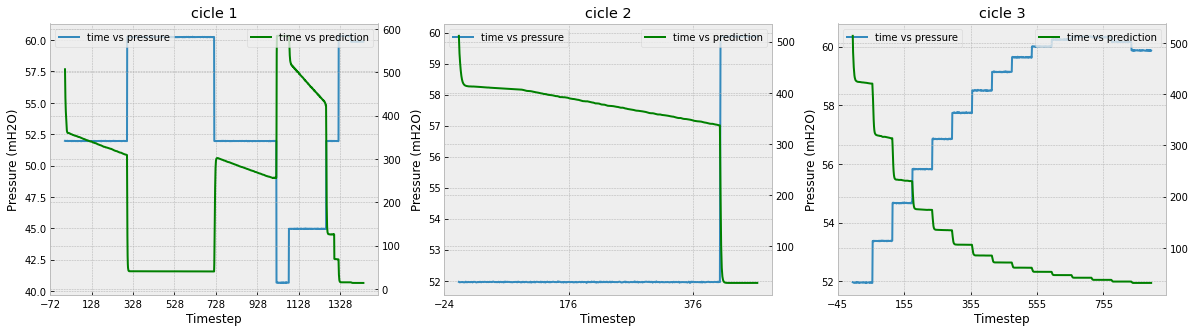

In [10]:
fig, ax1= plt.subplots(nrows=1,ncols=3,figsize=(20,5))
plt.style.use('bmh')
ind=0
for i in ax1:
  i.plot(graphs2.loc[graphs2['ciclo']==ind]['tiempo'],graphs2.loc[graphs2['ciclo']==ind]['presion'])
  ax2=i.twinx()
  ax2.plot(graphs2.loc[graphs2['ciclo']==ind]['tiempo'],graphs2.loc[graphs2['ciclo']==ind]['time_full2'],c='g')
  i.title.set_text(f'cicle {ind}')
  i.set_ylabel('Pressure (mH2O)')
  i.set_xlabel('Timestep')
  start,end=[0,0]
  start, end = i.get_xlim()
  i.xaxis.set_ticks(np.arange(start, end, 200))
  ind+=1
  i.title.set_text(f'cicle {ind}')
  i.legend(['time vs pressure'],loc='upper left')
  ax2.legend(['time vs prediction'],loc='upper right')

The graphs exhibited slightly but different behaviors when both models predicted each timestep. The first one shows a more suitable pattern when constant pressure appears on the system dynamics, maintaining a more stable likelihood over time. Another interesting difference lies in the time influence shown upon the second model. It tends to drop based on a linear pattern which, is an unwanted condition for our failure review hypothesis. 

Now let's check how each model behaves. We calculated the error for each of the 30 validation samples on the last timestep. Here are the distribution plots for each of the models. 


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2056: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2056

Text(0.5, 1.0, 'Model without indicators')

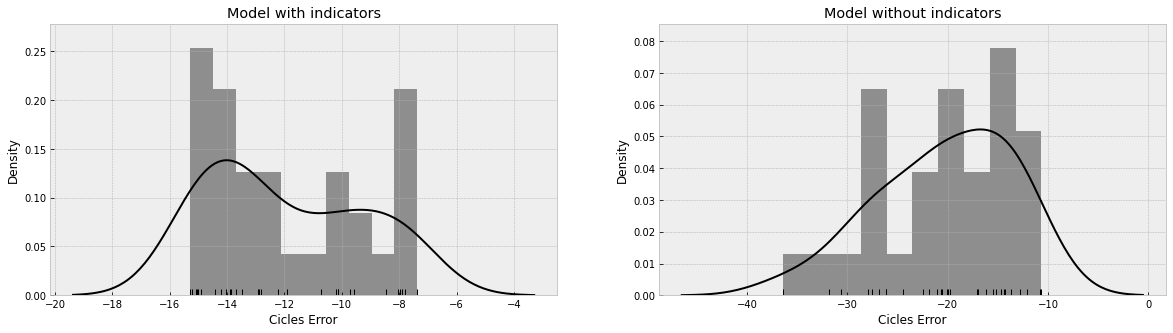

In [11]:
fig, ax1= plt.subplots(nrows=1,ncols=2,figsize=(20,5))
plt.style.use('bmh')
err=[]
for i in graphs['ciclo'].unique():
  error=graphs.loc[graphs['ciclo']==i]
  tiempo=error['tiempo'].max()  
  ciclos=float(error['time_full'][-1:])
  err.append((tiempo-(ciclos))-tiempo)
sns.distplot(err,kde=True,color='k',norm_hist=True,bins=10,rug=True,ax=ax1[0],axlabel='Cicles Error')
ax1[0].set_title('Model with indicators')
err2=[]
for i in graphs2['ciclo'].unique():
  error2=graphs2.loc[graphs2['ciclo']==i]
  tiempo2=error2['tiempo'].max()  
  ciclos2=float(error2['time_full2'][-1:])
  err2.append((tiempo2-(ciclos2))-tiempo2)
sns.distplot(err2,kde=True,color='k',norm_hist=True,bins=10,rug=True,ax=ax1[1],axlabel='Cicles Error')
ax1[1].set_title('Model without indicators')


Even though graphs didn't display high error values, the first model results performed better than those obtained by the second one. We identified better performance when analyzing error interval magnitude compared to using the maximum error value for each of the options. In conclusion, the model with indicators is a better fit for the data.


##Conclusions

So that's it. The above notebook allowed you to witness how our proven approach to pump failure prediction will work. Using statistics, we'll track duty point movement over pump performance curves; alongside resourceful indicators. Efficient, fast, and low trained data AI models will identify failure patterns prematurely using reasonable computational resources.

We know you might have numerous questions by now; we have them, too. Here are some answers to our immediate inquiries. Please, contact us at dnb0512@gmail.com if we did not overcome your initial questioning. 

Well, we already have a hypothesis of what might work after considerable learning from the model portrayed above. Our approach for failure uses system dynamics and pump components wear out.
- Many pumps use VFD nowadays; will it be compatible?

We certainly think so. Our approach uses pump performance without specifying any given frequency point: the normalization techniques mixed with affinity laws allow us to keep track of movement at any given frequency, including validation with systems that operate with variable frequency drives. 
- What are the next steps for the project?

We need operational data leading to failure data for as many scenarios as we can. We have fully developed a lab trial to obtain more than 300 series using ten pumps. However, our resources are scarce at the moment and, we are seeking partners that can help us achieve progress. Upon phase completion, we'll be working on the release of our first production model.

Thanks for reading up to this point; it means a lot to us.

🧠❤️ from 🇨🇴


